# Twitter Sentiment Analysis

Installing some packages and downloading data from Kaggle

In [1]:
!pip3 install ktrain
! pip install kaggle==1.5.6
! kaggle datasets download -d kazanova/sentiment140


  0%|          | 0.00/80.9M [00:00<?, ?B/s]
  1%|          | 1.00M/80.9M [00:00<00:24, 3.48MB/s]
  2%|▏         | 2.00M/80.9M [00:00<00:17, 4.82MB/s]
  4%|▎         | 3.00M/80.9M [00:00<00:18, 4.32MB/s]
  5%|▍         | 4.00M/80.9M [00:00<00:16, 4.96MB/s]
  6%|▌         | 5.00M/80.9M [00:01<00:13, 5.79MB/s]
  7%|▋         | 6.00M/80.9M [00:01<00:13, 5.95MB/s]
  9%|▊         | 7.00M/80.9M [00:01<00:17, 4.42MB/s]
 11%|█         | 9.00M/80.9M [00:01<00:10, 6.92MB/s]
 12%|█▏        | 10.0M/80.9M [00:01<00:10, 6.84MB/s]
 14%|█▎        | 11.0M/80.9M [00:01<00:10, 6.86MB/s]
 15%|█▍        | 12.0M/80.9M [00:02<00:10, 6.87MB/s]
 16%|█▌        | 13.0M/80.9M [00:02<00:11, 5.98MB/s]
 19%|█▊        | 15.0M/80.9M [00:02<00:10, 6.56MB/s]
 20%|█▉        | 16.0M/80.9M [00:02<00:10, 6.64MB/s]
 21%|██        | 17.0M/80.9M [00:02<00:09, 6.73MB/s]
 22%|██▏       | 18.0M/80.9M [00:03<00:10, 6.19MB/s]
 23%|██▎       | 19.0M/80.9M [00:03<00:10, 6.28MB/s]
 25%|██▍       | 20.0M/80.9M [00:03<00:09, 6.50MB/s]
 

## Importing libraries

In [2]:
# File management libraries
import os
import zipfile

# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Natural language processessing and text libraries
import nltk
import string
import re
from gensim.utils import simple_preprocess

# Scikit Learn libraries for splitting data and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Keras libraries for Neural Network development
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers, callbacks

# Library used to get the BERT Transformer model
import ktrain

## Reading the dataset

Extracting the file and reading it on a Pandas DataFrame.

In [3]:
with zipfile.ZipFile("sentiment140.zip","r") as zip_ref:
    zip_ref.extractall()

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'Latin-1', names=('target','id','date','flag','user','text'))

Since we have a limited space on the GitHub repository, we have to delete the zip and csv file to reduce space.

In [4]:
os.remove('training.1600000.processed.noemoticon.csv')
os.remove('sentiment140.zip')

The positive sentiment is labeled as the number 4 and usually is the number 1. To make it clear for now on, we create a column called "sentiment" with 1 as the positive label and 0 as the negative label. 

In [5]:
df['sentiment'] = (df['target'] == 4)*1
df.head()

,target,id,date,flag,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


Let's count the number of positives and negatives examples on the dataset. As we can se we have the same number for each sentiment.

In [6]:
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

## Data Prep

When we are dealing with text-type data, we need to treat it in a way that we and the possible machine learning models that we make can use it in the best way. Two of the ways to handle text data are the removal of punctuation and stop words, which are quite common words that in general would not help us to differentiate a positive feeling from a negative one because they are present in both cases. Also, on Twitter texts are very common the presence of @mentions and #hashtags that requires some treatment as well.

a) Removing tweet patterns

Removing @mentions, the "#" symbol and URLs starting with "https" or "http".

In [7]:
def twitter_text_cleaning(text):
  '''
  INPUT
  text - a text message that might have @mentions, "#" symbol or URLs
    
  OUTPUT
  text - the text without @mentions, "#" and URLs
  '''

  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)
  text = re.sub(r'@[A-Za-z0-9_]+','', text)
  text = re.sub(r'@[A-Za-z]+', '', text)
  text = re.sub(r'@[-)]+', '', text)
  text = re.sub(r'#', '', text )
  text = re.sub(r'https?\/\/\S+', '', text)
  text = re.sub(r'http?\/\/\S+', '', text)

  return text

df['cleaned_text'] = df['text'].apply(twitter_text_cleaning)

b) Removing punctuations

In [8]:
def remove_punc(message):
  '''
  INPUT
  message - a text message that might have puntuations in it
    
  OUTPUT
  message without punctuations
  '''

  return ''.join([char for char in message if char not in string.punctuation])

df['cleaned_text_wo_punctuation'] = df['cleaned_text'].apply(remove_punc)

c) Removing stopwords

In [9]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year', 'https', 'amp'])
print('Some examples of Stop Words: \n', stop_words[:10])

Some examples of Stop Words: 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def stop_words_preprocess(text):
  '''
  INPUT
  text - a text message that might have stop words
    
  OUTPUT
  list of words without stop words examples
  '''

  return [word for word in simple_preprocess(text) if word not in stop_words and len(word) >= 3]

In [11]:
df['cleaned_text_wo_punctuation_and_stopwords'] = df['cleaned_text_wo_punctuation'].apply(stop_words_preprocess)
df['preprocessed_text'] = df['cleaned_text_wo_punctuation_and_stopwords'].apply(lambda x: " ".join(x))

The final DataFrame with examples of every text preprocessing will be like

In [12]:
df.head()

,target,id,date,flag,user,text,sentiment,cleaned_text,cleaned_text_wo_punctuation,cleaned_text_wo_punctuation_and_stopwords,preprocessed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,"http://twitpic.com/2y1zl - Awww, that's a bum...",httptwitpiccom2y1zl Awww thats a bummer You...,"[httptwitpiccom, awww, thats, bummer, shoulda,...",httptwitpiccom awww thats bummer shoulda got d...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,"[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,I dived many times for the ball. Managed to s...,I dived many times for the ball Managed to sa...,"[dived, many, times, ball, managed, save, rest...",dived many times ball managed save rest bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]",whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0,"no, it's not behaving at all. i'm mad. why am...",no its not behaving at all im mad why am i he...,"[behaving, mad, cant, see]",behaving mad cant see


## Analysis

### 1. What are the most common words in POSITIVE sentiment tweets? And what words are for the NEGATIVES? 

A good way to visualize the most common words in sentences is by using Word Cloud visualization. In a Word Cloud the more frequent a word is the bigger the word will be on the picture.

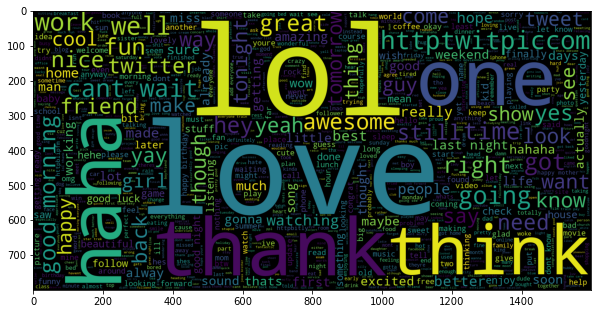

In [13]:
plt.figure(figsize= (10,10))
wc = WordCloud(
    max_words=1000, 
    width=1600,
    height=800
).generate(' '.join(df[df['sentiment'] == 1]['preprocessed_text']))
wc.to_file('images/wordcloud_positive_words.png')
plt.imshow(wc)

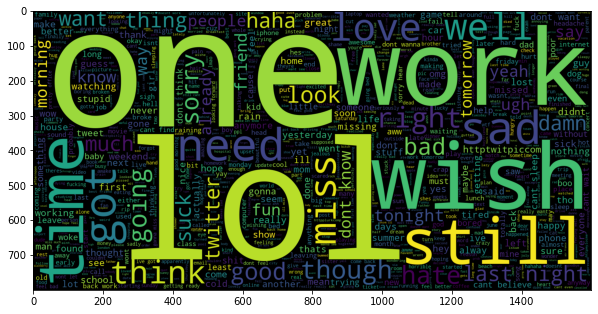

In [14]:
plt.figure(figsize= (10,10))
wc = WordCloud(
    max_words=1000, 
    width=1600,
    height=800
).generate(' '.join(df[df['sentiment'] == 0]['preprocessed_text']))
wc.to_file('images/wordcloud_negative_words.png')
plt.imshow(wc)

### 2. Which high engaging users usually tweets more positives than negatives tweets? And which users do the oposite?

First, let's count the number of tweets from a user.

In [81]:
sentiment_per_user_df = df.groupby('user').agg({'sentiment':'mean','text':'count'})\
.reset_index().rename(columns={"sentiment": "average_sentiment", 'text' : 'tweets_number'})

sentiment_per_user_df.head()

,user,average_sentiment,tweets_number
0,000catnap000,0.833333,6
1,000matthewkelly,1.000000,1
2,000yea000,1.000000,1
3,0010x0010,1.000000,1
4,001BabyGirl,1.000000,2


Then, we define some ranges according to the number of tweets made by an user.

In [82]:
def tweets_range(tweets_number):
  '''
  INPUT
  tweets_number - number of tweets

  OUTPUT
  tweet_range - interval of number of tweets
  '''

  if tweets_number == 1:
    return '1. Only 1 tweet'
  
  if tweets_number <= 5:
    return '2. Between 2 and 5 tweets'

  if tweets_number <= 10:
    return '3. Between 6 and 10 tweets'

  if tweets_number <= 20:
    return '4. Between 11 and 20 tweets'

  if tweets_number <= 50:
    return '5. Between 21 and 50 tweets'

  if tweets_number <= 100:
    return '6. Between 51 and 100 tweets'

  return '7. 101 or more tweets'

sentiment_per_user_df['tweets_range'] = sentiment_per_user_df['tweets_number'].apply(tweets_range)

Now, let's count the number of users per tweets range. 

In [83]:
tweets_range_df = sentiment_per_user_df.groupby('tweets_range').average_sentiment.count().reset_index()
tweets_range_df = tweets_range_df.rename(columns={"average_sentiment": "users"})
tweets_range_df['%users'] = round(100*tweets_range_df['users']/tweets_range_df['users'].sum(),2)
tweets_range_df

,tweets_range,users,%users
0,1. Only 1 tweet,405277,61.43
1,2. Between 2 and 5 tweets,203925,30.91
2,3. Between 6 and 10 tweets,31975,4.85
3,4. Between 11 and 20 tweets,12873,1.95
4,5. Between 21 and 50 tweets,4848,0.73
5,6. Between 51 and 100 tweets,716,0.11
6,7. 101 or more tweets,161,0.02


Finally, we can find the high engaging users that has on average more positives than negatives tweets and the users that has more negatives than positives tweets.

In [84]:
sentiment_per_user_df[sentiment_per_user_df['tweets_range'] == '7. 101 or more tweets'] \
.sort_values(["average_sentiment", "tweets_number"], ascending = (False, False)).head(10)

,user,average_sentiment,tweets_number,tweets_range
642554,what_bugs_u,1.0,246,7. 101 or more tweets
118008,KevinEdwardsJr,1.0,171,7. 101 or more tweets
643270,whitsundays,1.0,144,7. 101 or more tweets
473518,longestpoem,1.0,116,7. 101 or more tweets
366062,figPYBFO,1.0,114,7. 101 or more tweets
630367,tweeteradder7,1.0,114,7. 101 or more tweets
630360,tweeteradder2,1.0,113,7. 101 or more tweets
2919,5toSucceed,1.0,109,7. 101 or more tweets
28738,BlokesLib,1.0,109,7. 101 or more tweets
558116,redrobinrockn,1.0,107,7. 101 or more tweets


In [85]:
sentiment_per_user_df[sentiment_per_user_df['tweets_range'] == '7. 101 or more tweets'] \
.sort_values(["average_sentiment", "tweets_number"], ascending = (True, False)).head(10)

,user,average_sentiment,tweets_number,tweets_range
474340,lost_dog,0.000000,549,7. 101 or more tweets
630446,tweetpet,0.000000,310,7. 101 or more tweets
646233,wowlew,0.009434,212,7. 101 or more tweets
197390,SarahMorrison,0.038462,104,7. 101 or more tweets
578702,sebby_peek,0.067961,103,7. 101 or more tweets
128731,Leanne0710,0.069307,101,7. 101 or more tweets
181987,QueenBxoxo,0.163636,110,7. 101 or more tweets
507057,mlexiehayden,0.179245,106,7. 101 or more tweets
344703,dontforgetchaos,0.194030,134,7. 101 or more tweets
445612,keren4562,0.195312,128,7. 101 or more tweets


### 3. Does the NUMBER OF WORDS in a tweet help determine whether it has positive or negative sentiment?

In [16]:
df['num_words'] = df['cleaned_text_wo_punctuation_and_stopwords'].apply(lambda x : len(x))

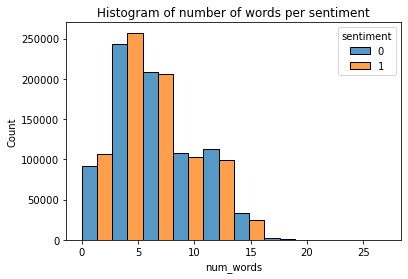

In [17]:
sns.histplot(data=df, x="num_words", hue="sentiment", bins = 10,  multiple="dodge")
plt.title('Histogram of number of words per sentiment')
plt.savefig('images/histogram_number_words_per_sentiment.png', dpi='figure', backend=None)
plt.show()

### 4. Does the tweet's LENGHT help determine whether it has positive or negative sentiment?

In [19]:
df['tweet_lenght'] = df['text'].apply(lambda x : len(x))

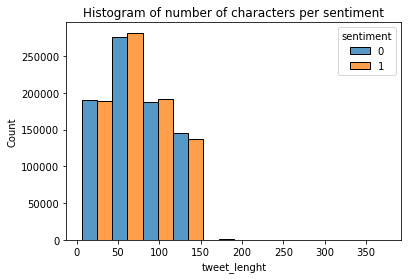

In [20]:
sns.histplot(data=df, x="tweet_lenght", hue="sentiment", bins = 10,  multiple="dodge")
plt.title('Histogram of number of characters per sentiment')
plt.savefig('images/histogram_number_characters_per_sentiment.png', dpi='figure', backend=None)
plt.show()

### 5. Is it possible to predict the sentiment of a new tweet using the existing ones?

#### a) Spliting the data in training, validation and test sets

In order to reduce the time training the models and because we have limited CPU and GPU resources, we are going to reduce the dataset 

In [125]:
np.random.seed(42)
reduced_df = df.sample(int(len(df)*0.1))
print(f'New dataset size {len(reduced_df)} ({round(100*len(reduced_df)/len(df))}% of the original dataset)')

New dataset size 160000 (10% of the original dataset)


First, we select the columns which we are going to use to train the models (cleaned_text for features and sentiment for target) 

In [126]:
X = reduced_df['preprocessed_text']
y = reduced_df['sentiment']

Splitting the dataset in training, validation and test set. The training set is used to train our models and the validation set it's used for measure how well our model perform on new data helping identify some underfitting or overfitting situations. Finally, the test set it's only used once when we are confident on the best model results and verify how it perform in another new data, but this time the test set was not used the choose the best model as we did with the validation set.

In [127]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 0.25, random_state=42)

The number of examples and percentage of every set.

In [128]:
print(f'Train set size: {X_train.shape[0]} ({round(100*X_train.shape[0]/reduced_df.shape[0],1)}%)')
print(f'Validation set size: {X_val.shape[0]} ({round(100*X_val.shape[0]/reduced_df.shape[0],1)}%)')
print(f'Test set size: {X_test.shape[0]} ({round(100*X_test.shape[0]/reduced_df.shape[0],1)}%)')

Train set size: 108000 (67.5%)
Validation set size: 36000 (22.5%)
Test set size: 16000 (10.0%)


#### b) Data prep using Keras Tokenizer

We are using the Keras Tokenizer class in order to convert words into numbers, so our models could use it properly (some examples below).

In [129]:
tokenizer = text.Tokenizer(num_words=2000000)
tokenizer.fit_on_texts(X_train)

We have a total of 69489 distinct words on the training set

In [130]:
total_words = len(tokenizer.word_index)
total_words

69489

Converting the text into numbers (tokens).

In [131]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

Using the padding function to make all the examples with the same input size.

In [132]:
padded_train = sequence.pad_sequences(train_sequences, maxlen = 30)
padded_val = sequence.pad_sequences(val_sequences, maxlen = 30)

Examples of the tokenizer and the padding preprocessing.

In [133]:
X_train[:5]

792113     questions way hard meant know shakespeares aud...
919355     walking dog horseforth park hangover sunday mo...
1105358    watchoutnow lol havent forgotten yagot lil sid...
738376          aww damn jejos sick three days hospital time
187954                         bed teary eyed want foooodddd
Name: preprocessed_text, dtype: object

In [134]:
train_sequences[:5]

[[1733, 51, 176, 692, 14, 23415, 23416, 23417, 1188, 6880, 12584, 685],
 [779, 381, 23418, 598, 854, 210, 32, 113],
 [23419, 10, 159, 2865, 23420, 498, 12585, 206, 16041, 5177, 276],
 [212, 131, 23421, 84, 529, 70, 787, 12],
 [62, 12586, 4872, 20, 23422]]

In [135]:
padded_train[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         1733,    51,   176,   692,    14, 23415, 23416, 23417,  1188,
         6880, 12584,   685],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   779,   381, 23418,   598,   854,
          210,    32,   113],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 23419,    10,   159,  2865, 23420,   498, 12585,   206,
        16041,  5177,   276],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   212,   131, 23421,    84,   529,
           70,   787,    12],
       [    0,     0,     0,

For the target variable, we are using the One Hot Encoding technique to get the probability for each sentiment, and use it if we need.

In [136]:
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

Examples showing the One Hot Encoding technique.

In [137]:
y_train[:5].values

array([0, 1, 1, 0, 0], dtype=int64)

In [138]:
y_train_cat[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#### c) Creating a LSTM Neural Networks

In [139]:
lstm_model = models.Sequential()
lstm_model.add(layers.Embedding(input_dim = total_words, output_dim=1024))

lstm_model.add(layers.LSTM(256))

lstm_model.add(layers.Dense(128, activation='relu'))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(2, activation='softmax'))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 1024)        71156736  
                                                                 
 lstm_1 (LSTM)               (None, 256)               1311744   
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 72,501,634
Trainable params: 72,501,634
Non-trainable params: 0
_________________________________________________________________


We are using Adam optimizer and setting a callback to stop the model training early if our metrics does not get better per epoch.

In [140]:
adam = optimizers.Adam(learning_rate=0.0001)
early = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Since we have about the same number of positives and negatives examples we can use accuracy as classification metric to choose the best model. If that wasn't the case, we should use balanced accuracy in order to get a better view for classification of both classes.

In [141]:
y_train.value_counts()

1    54086
0    53914
Name: sentiment, dtype: int64

In [142]:
lstm_model.compile(
    optimizer = adam, 
    loss = 'categorical_crossentropy', 
    metrics = ['acc']
)

Now, let's train our LSTM model

In [143]:
lstm_model.fit(
    padded_train, y_train_cat, 
    epochs=20, 
    batch_size=100, 
    validation_data=(padded_val, y_val_cat),
    callbacks = [early]
)

Epoch 1/20
1080/1080 [==============================] - 33s 28ms/step - loss: 0.5296 - acc: 0.7305 - val_loss: 0.4833 - val_acc: 0.7684
Epoch 2/20
1080/1080 [==============================] - 30s 28ms/step - loss: 0.4204 - acc: 0.8108 - val_loss: 0.4959 - val_acc: 0.7624
Epoch 3/20
1080/1080 [==============================] - 30s 28ms/step - loss: 0.3511 - acc: 0.8482 - val_loss: 0.5287 - val_acc: 0.7529
Epoch 4/20
1080/1080 [==============================] - 30s 28ms/step - loss: 0.2899 - acc: 0.8762 - val_loss: 0.5871 - val_acc: 0.7464
Epoch 5/20
1080/1080 [==============================] - 30s 28ms/step - loss: 0.2442 - acc: 0.8943 - val_loss: 0.6908 - val_acc: 0.7444
Epoch 6/20
1080/1080 [==============================] - 30s 28ms/step - loss: 0.2120 - acc: 0.9077 - val_loss: 0.7672 - val_acc: 0.7380


With our trained model we can predict the sentiment and measure it's accuracy.

In [144]:
lstm_train_pred = lstm_model.predict(padded_train)
lstm_val_pred = lstm_model.predict(padded_val)

In [145]:
lstm_train_pred = np.argmax(lstm_train_pred, axis=1)
lstm_val_pred = np.argmax(lstm_val_pred, axis=1)

In [146]:
accuracy_score(y_train, lstm_train_pred)

0.8187592592592593

In [147]:
accuracy_score(y_val, lstm_val_pred)

0.7684444444444445

#### d) Creating a Transformer Deep Network with BERT

Transformers are a type of Neural Networks that differs from others by using a "Attention" layer. It creates a relationship between each word and any other word ignoring the order of the words in the sentence but it comes with the cost of using a lot of memory to store all the neural network weights. 

BERT: Biderectional Encoder Representations from Transformer is a Transformer encoder trained on Wikipedia data. Since it is a a pre-trained model, we can fine tune it to retrain using our data.

Creating our features and target variables.

In [148]:
X = reduced_df[['preprocessed_text', 'target']]
y = reduced_df['sentiment']

Sppliting our data as we did before.

In [149]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 0.25, random_state=42)

In [150]:
print(f'Train set size: {X_train.shape[0]} ({round(100*X_train.shape[0]/reduced_df.shape[0],1)}%)')
print(f'Validation set size: {X_val.shape[0]} ({round(100*X_val.shape[0]/reduced_df.shape[0],1)}%)')
print(f'Test set size: {X_test.shape[0]} ({round(100*X_test.shape[0]/reduced_df.shape[0],1)}%)')

Train set size: 108000 (67.5%)
Validation set size: 36000 (22.5%)
Test set size: 16000 (10.0%)


Creating one DataFrame for training and validation sets because ktrain package requires DataFrames instead of numpy series.

In [151]:
train_df = X_train.copy()
train_df['sentiment'] = y_train

val_df = X_val.copy()
val_df['sentiment'] = y_val

Getting the biggest sentence lenght to be used to preprocess the data.

In [152]:
sentence_lenghts = X_train['preprocessed_text'].apply(lambda x: len(x))

In [153]:
max_sentence_lenght = sentence_lenghts.max()
max_sentence_lenght

128

In order to train our BERT model, we need to use the same data preprocessing used to train it. So we are going to this preprocessing on our data.

In [154]:
(x_train, y_train), (x_val, y_val), preproc = ktrain.text.texts_from_df(
    train_df=train_df, 
    text_column='preprocessed_text', 
    label_columns=['sentiment'], 
    val_df=val_df, 
    max_features=20000, 
    maxlen=max_sentence_lenght, 
    preprocess_mode='bert', 
    random_state=42, 
    verbose=1
  )

['not_sentiment', 'sentiment']
         not_sentiment  sentiment
792113             1.0        0.0
919355             0.0        1.0
1105358            0.0        1.0
738376             1.0        0.0
187954             1.0        0.0
['not_sentiment', 'sentiment']
         not_sentiment  sentiment
84910              1.0        0.0
1240991            0.0        1.0
426435             1.0        0.0
793017             1.0        0.0
674790             1.0        0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Let's import the BERT classifier and set the training and validation sets.

In [155]:
bert_model = ktrain.text.text_classifier('bert', (x_train, y_train), preproc=preproc)
bert_learner = ktrain.get_learner(
    bert_model, 
    train_data=(x_train, y_train), 
    val_data=(x_val, y_val), 
    batch_size=32
)

Is Multi-Label? False
maxlen is 128
done.


Now, let's train our BERT model (be aware that it might take a while).

In [156]:
bert_learner.fit_onecycle(2e-5, 5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
3375/3375 [==============================] - 1859s 545ms/step - loss: 0.4976 - accuracy: 0.7549 - val_loss: 0.4514 - val_accuracy: 0.7907
Epoch 2/5
3375/3375 [==============================] - 1837s 544ms/step - loss: 0.4311 - accuracy: 0.8008 - val_loss: 0.4455 - val_accuracy: 0.7975
Epoch 3/5
3375/3375 [==============================] - 1838s 544ms/step - loss: 0.3690 - accuracy: 0.8354 - val_loss: 0.4433 - val_accuracy: 0.7963
Epoch 4/5
3375/3375 [==============================] - 1836s 544ms/step - loss: 0.2389 - accuracy: 0.9020 - val_loss: 0.5667 - val_accuracy: 0.7893
Epoch 5/5
3375/3375 [==============================] - 1837s 544ms/step - loss: 0.1232 - accuracy: 0.9518 - val_loss: 0.7761 - val_accuracy: 0.7855


Loading our predictor from the trained model.

In [157]:
bert_predictor = ktrain.get_predictor(bert_learner.model, preproc)

Predicting the sentiment for training and validation sets and calculating the accuracy.

In [158]:
bert_train_pred = bert_predictor.predict(X_train['preprocessed_text'].values)
bert_val_pred = bert_predictor.predict(X_val['preprocessed_text'].values)

In [159]:
bert_train_pred = (np.array(bert_train_pred) == 'sentiment')*1
bert_val_pred = (np.array(bert_val_pred) == 'sentiment')*1

In [160]:
accuracy_score(np.argmax(y_train, axis=1), bert_train_pred)

0.9834259259259259

In [161]:
accuracy_score(np.argmax(y_val, axis=1), bert_val_pred)

0.7855

Since we got a better accuracy using the BERT model on the validation set, we are going to use this model to predict on our test set and calculate the accuracy.

In [162]:
bert_test_pred = bert_predictor.predict(X_test['preprocessed_text'].values)

In [163]:
bert_test_pred = (np.array(bert_test_pred) == 'sentiment')*1

In [164]:
accuracy_score(y_test, bert_test_pred)

0.7834375

#### e) Using the model in other tweets

Now we are going to test our model in some recent tweets and see how it performs. When a tweet is classified as "sentiment" it means it is a positive sentiment by the model and a "not_sentiment" classification means a negative sentiment.

![elon1.png](elon1.png)

In [165]:
bert_predictor.predict('Tesla holiday software update goes to wide release today!')

'sentiment'

![biden1.png](biden1.png)

In [166]:
bert_predictor.predict('Clean water for every American. We’ve never done that. And now we are. High-speed internet for every American.  We’ve never done that. And now we are. As a nation, we’ve only scratched the surface of what we’re capable of.')

'sentiment'

![tim1.png](tim1.png)

In [167]:
bert_predictor.predict('Our hearts go out to all those affected by the devastating weather and tornadoes across the South and Midwest. Apple will be donating to support relief efforts on the ground.')

'sentiment'

![bill1.png](bill1.png)

In [168]:
bert_predictor.predict('Just when it seemed like life would return to normal, we could be entering the worst part of the pandemic. Omicron will hit home for all of us. Close friends of mine now have it, and I’ve canceled most of my holiday plans.')

'not_sentiment'

In [169]:
bert_predictor.predict('If there’s good news here, it’s that omicron moves so quickly that once it becomes dominant in a country, the wave there should last less than 3 months. Those few months could be bad, but I still believe if we take the right steps, the pandemic can be over in 2022.')

'sentiment'

In [170]:
bert_predictor.predict('I know it’s frustrating to go into another holiday season with COVID looming over us. But it won’t be like this forever. Someday the pandemic will end, and the better we look after each other, the sooner that time will come.')

'not_sentiment'